Loading existing features from ./results_classical/features_mfcc.csv...

--- Generating MFCC Heatmaps for Representatives ---


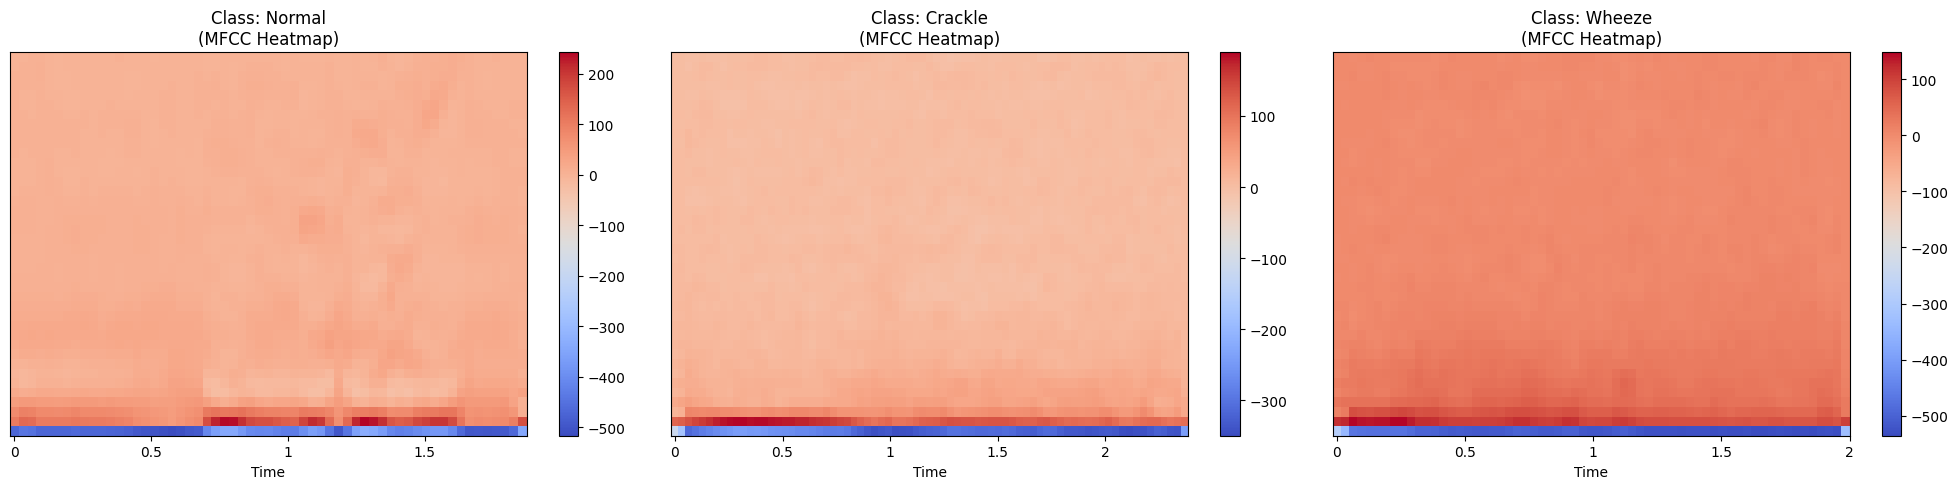


--- Identifying Significant Features (ANOVA & PCA) ---
ANOVA Results saved to: ./results_classical/feature_importance_anova.csv

Top 10 Significant Features (ANOVA):
         Feature    F_Score       P_Value
62  mfcc_mean_32  72.037917  1.079915e-29
21   mfcc_std_11  50.042868  2.629327e-21
0    mfcc_mean_1  43.108918  1.387144e-18
66  mfcc_mean_34  41.880710  4.250113e-18
35   mfcc_std_18  39.554559  3.571087e-17
37   mfcc_std_19  34.905598  2.593149e-15
23   mfcc_std_12  30.077301  2.323228e-13
25   mfcc_std_13  29.552268  3.798344e-13
41   mfcc_std_21  29.358905  4.552868e-13
13    mfcc_std_7  27.597982  2.379066e-12

--- Computing Principal Component Analysis (PCA) ---

Explained Variance Ratio (Top 10 Components):
[0.25547348 0.11079048 0.07421931 0.0588725  0.05532596 0.0406311
 0.03739458 0.0318323  0.02269819 0.02091991]
Total Variance Explained by PC1 & PC2: 36.63%
PCA Loadings saved to: ./results_classical/pca_loadings.csv


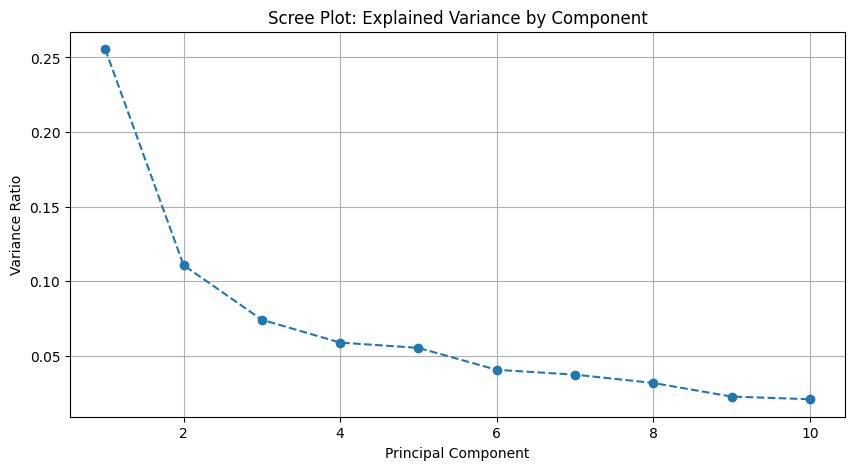

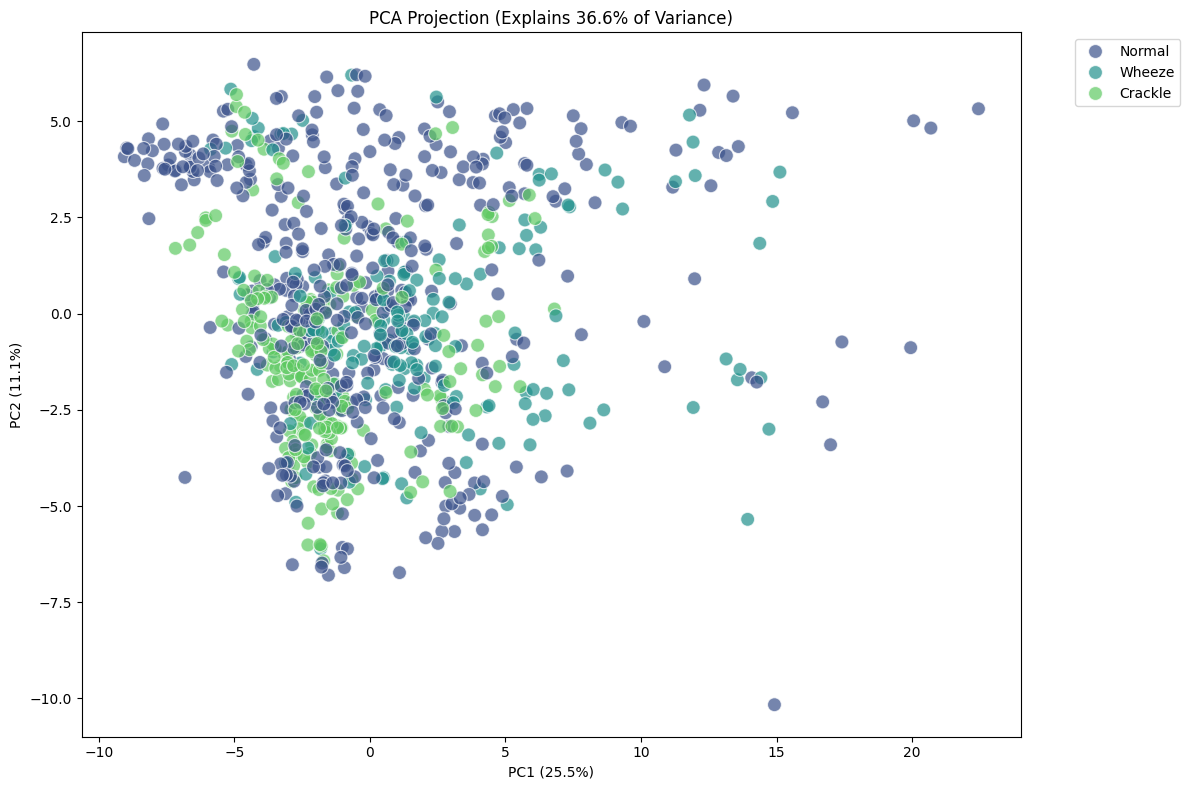


--- Analyzing Descriptive Features by Class ---
Class feature profiles saved to: ./results_classical/class_feature_profiles.csv


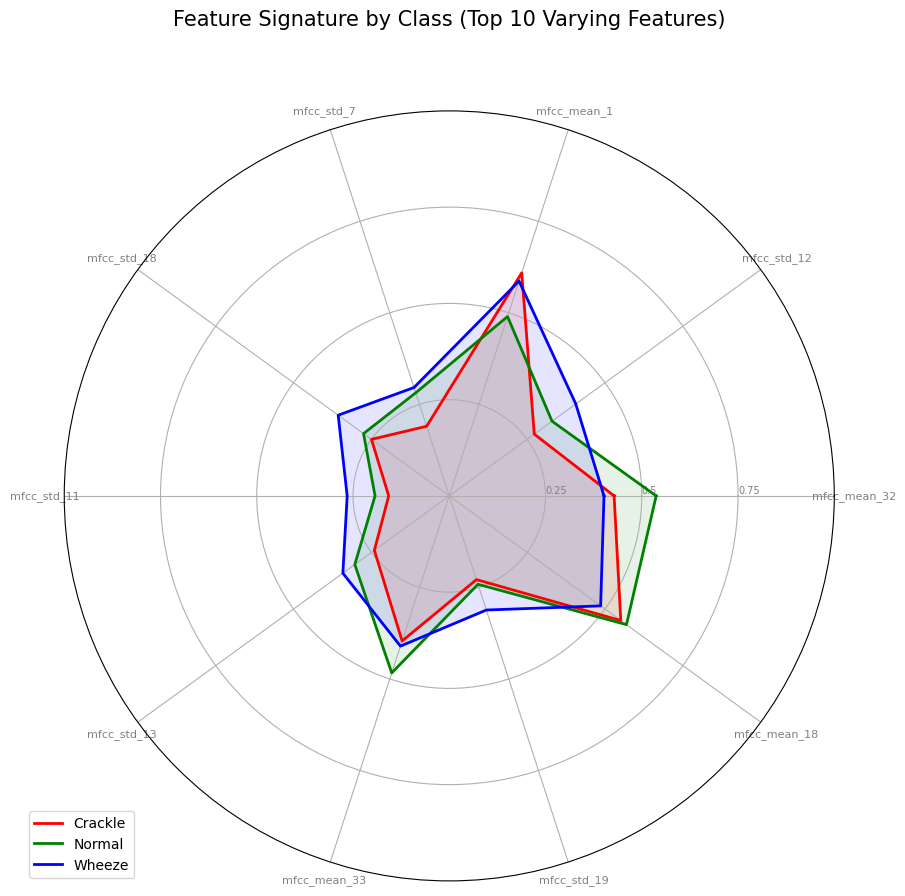


Generating Boxplots for Top 3 Discriminative Features...


C:\Users\User\AppData\Local\Temp\ipykernel_21168\3051155597.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df, ax=axes[i], palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_21168\3051155597.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df, ax=axes[i], palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_21168\3051155597.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df, ax=axes[i], palette='viridis')


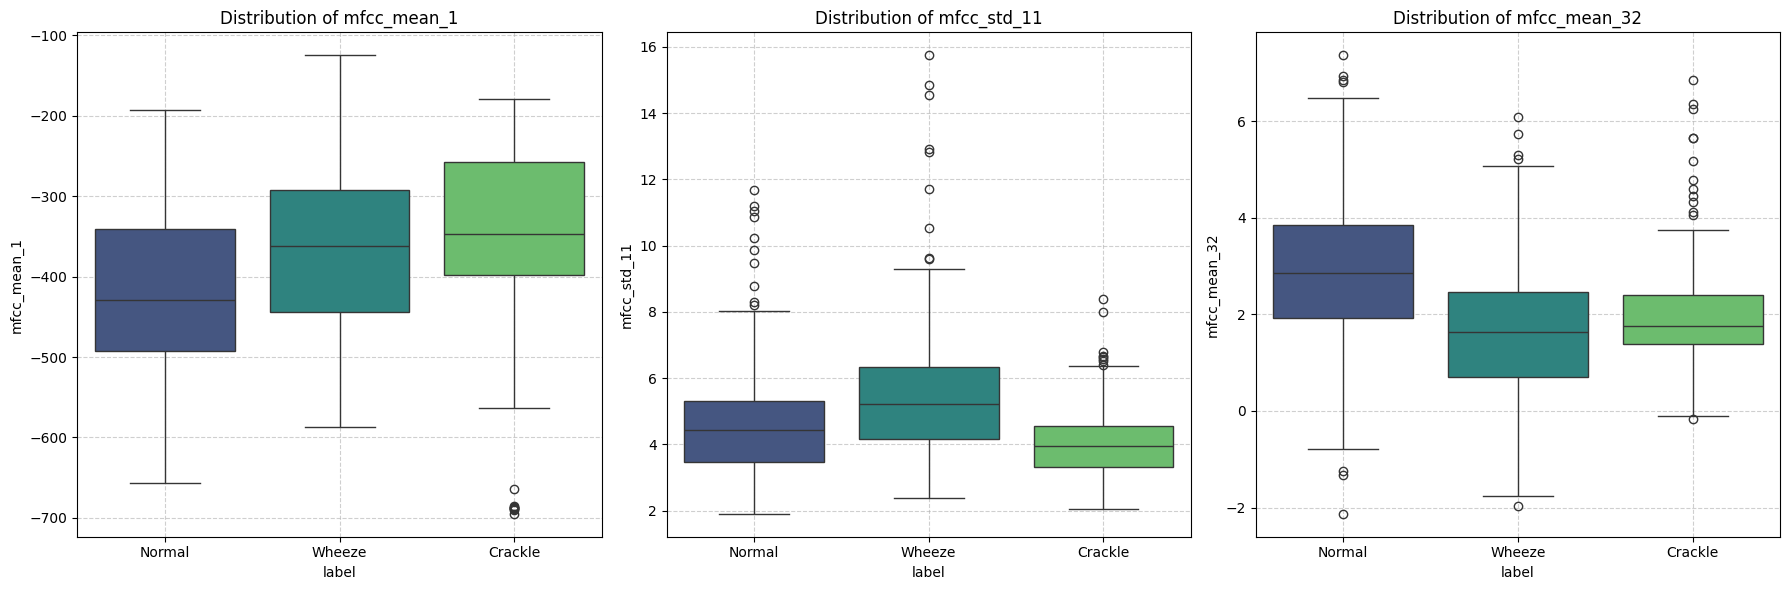


--- distinctive Feature Report ---
Feature 'mfcc_mean_1':
  > Highest in: Crackle (Mean: -347.56)
  > Lowest in:  Normal (Mean: -415.66)
  > Interpretation: This feature helps distinguish Crackle from Normal.
------------------------------
Feature 'mfcc_std_11':
  > Highest in: Wheeze (Mean: 5.57)
  > Lowest in:  Crackle (Mean: 4.08)
  > Interpretation: This feature helps distinguish Wheeze from Crackle.
------------------------------
Feature 'mfcc_mean_32':
  > Highest in: Normal (Mean: 2.97)
  > Lowest in:  Wheeze (Mean: 1.69)
  > Interpretation: This feature helps distinguish Normal from Wheeze.
------------------------------

--- Training & Fine-Tuning Models (5-Fold CV) ---
✅ Label Encoder saved to ./results_classical/deployable_models
✅ Scaler saved to ./results_classical/deployable_models
Training 6 models...

🔹 Processing SVM...
   > Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
   > CV Mean Accuracy: 0.8025
   > Test Accuracy:    0.8409
   > Model saved to: ./resu

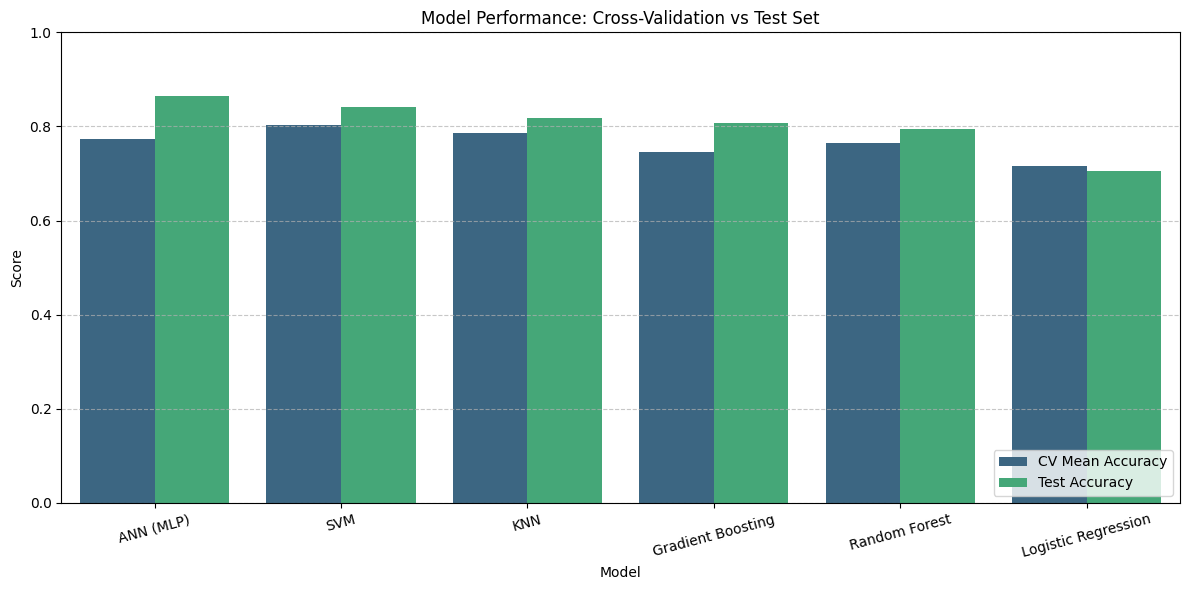

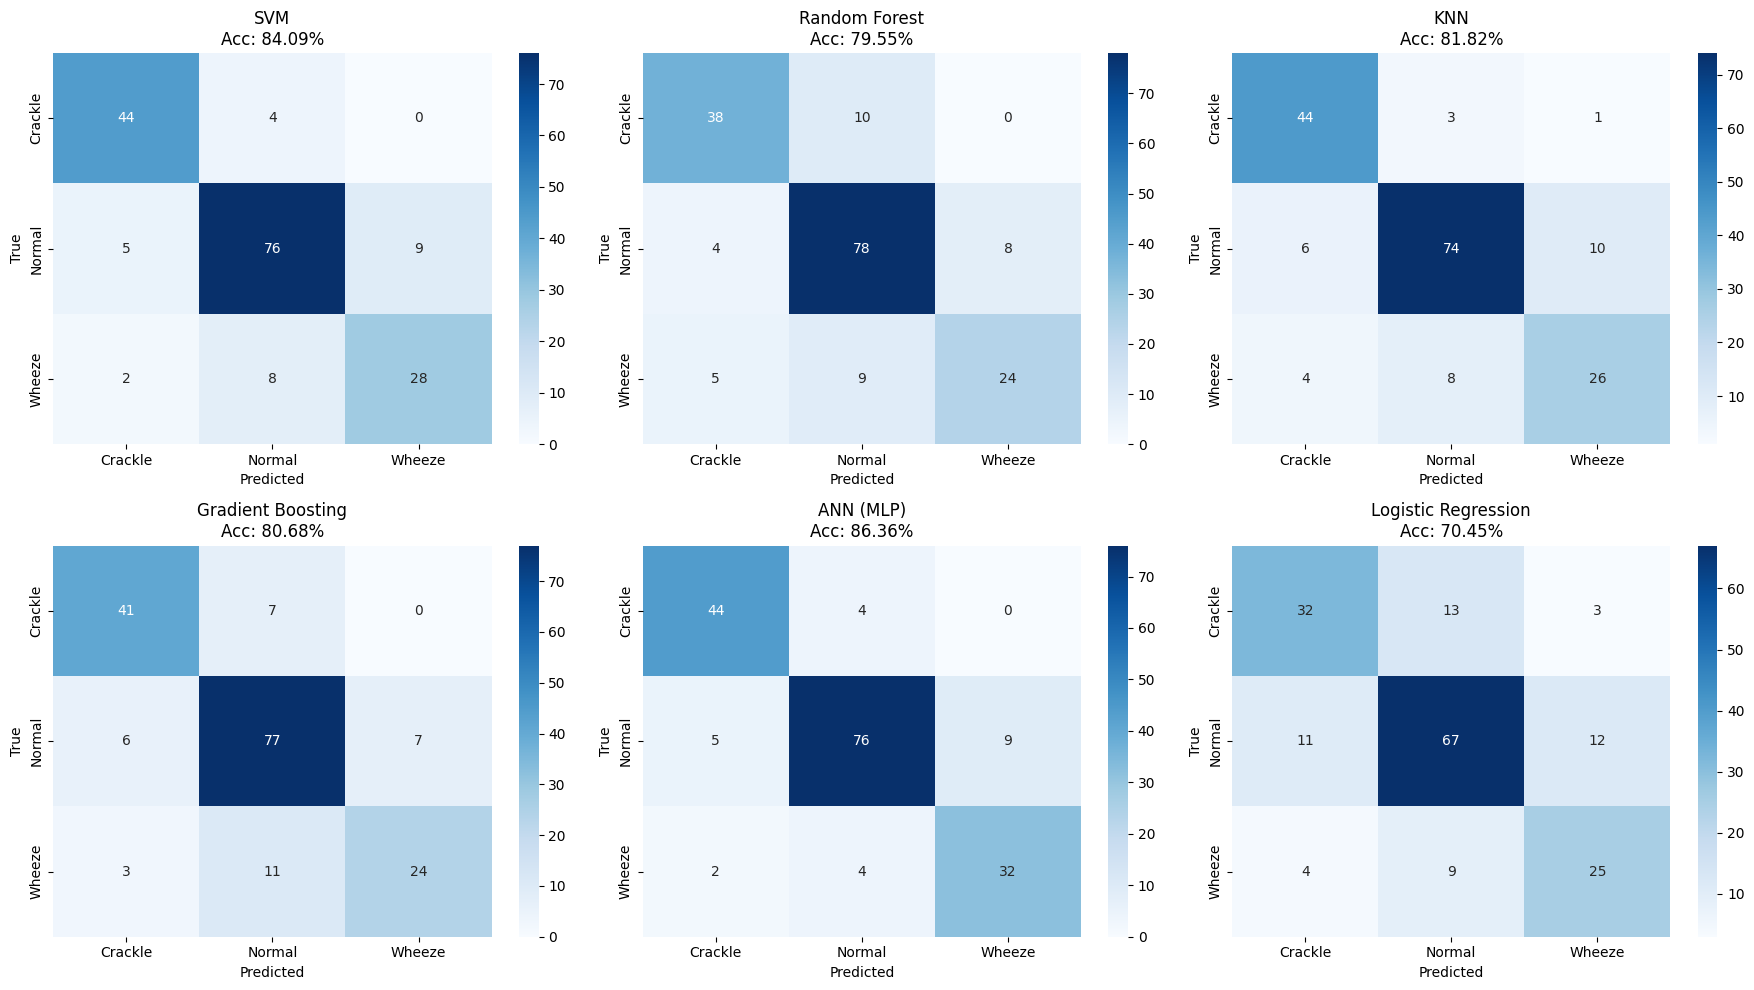


--- Final Model Leaderboard ---
                 Model  Test Accuracy  CV Mean Accuracy  \
4            ANN (MLP)       0.863636          0.772705   
0                  SVM       0.840909          0.802533   
2                  KNN       0.818182          0.785502   
3    Gradient Boosting       0.806818          0.745714   
1        Random Forest       0.795455          0.765583   
5  Logistic Regression       0.704545          0.715836   

                                          Saved Path  
4  ./results_classical/deployable_models\ANN_(MLP...  
0   ./results_classical/deployable_models\SVM.joblib  
2   ./results_classical/deployable_models\KNN.joblib  
3  ./results_classical/deployable_models\Gradient...  
1  ./results_classical/deployable_models\Random_F...  
5  ./results_classical/deployable_models\Logistic...  


In [22]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# --- CONFIGURATION ---
DATASET_DIR = 'dataset'  # UPDATE THIS PATH
SAVE_DIR = './results_classical/'
os.makedirs(SAVE_DIR, exist_ok=True)

SAMPLE_RATE = 16000
N_MFCC = 40 

# --- 1. FEATURE EXTRACTION & SAVING ---
def get_label(crackle, wheeze):
    if crackle == 0 and wheeze == 0: return 'Normal'
    if crackle == 1 and wheeze == 0: return 'Crackle'
    if crackle == 0 and wheeze == 1: return 'Wheeze'
    return 'Wheeze' # Merge 'Both' into Wheeze

def extract_and_save_features():
    features_path = os.path.join(SAVE_DIR, 'features_mfcc.csv')
    
    if os.path.exists(features_path):
        print(f"Loading existing features from {features_path}...")
        return pd.read_csv(features_path)
    
    print("Starting Fresh Feature Extraction...")
    data_records = []
    txt_files = [f for f in os.listdir(DATASET_DIR) if f.endswith('.txt')]

    for txt_file in tqdm(txt_files):
        base_name = txt_file.split('.')[0]
        wav_file = os.path.join(DATASET_DIR, base_name + '.wav')
        
        if not os.path.exists(wav_file): continue
        
        full_audio, sr = librosa.load(wav_file, sr=SAMPLE_RATE)
        annotations = pd.read_csv(os.path.join(DATASET_DIR, txt_file), sep='\t', header=None, names=['start', 'end', 'crackle', 'wheeze'])
        
        for _, row in annotations.iterrows():
            start = int(row['start'] * sr)
            end = int(row['end'] * sr)
            
            if end > len(full_audio) or (end - start) < (0.2 * sr): continue
            
            audio_seg = full_audio[start:end]
            label = get_label(row['crackle'], row['wheeze'])
            
            # Extract MFCCs
            mfccs = librosa.feature.mfcc(y=audio_seg, sr=sr, n_mfcc=N_MFCC)
            
            # Calculate Statistics
            mfcc_mean = np.mean(mfccs, axis=1)
            mfcc_std = np.std(mfccs, axis=1)
            
            record = {'label': label}
            for i in range(N_MFCC):
                record[f'mfcc_mean_{i+1}'] = mfcc_mean[i]
                record[f'mfcc_std_{i+1}'] = mfcc_std[i]
            
            data_records.append(record)
            
    df = pd.DataFrame(data_records)
    df.to_csv(features_path, index=False)
    print(f"Features saved to {features_path}")
    return df

# --- 2. VISUALIZATION (HEATMAPS) ---
def visualize_representative_samples(dataset_dir):
    """
    Finds one example for each class and plots the Raw MFCC Heatmap.
    """
    print("\n--- Generating MFCC Heatmaps for Representatives ---")
    classes_found = []
    target_classes = ['Normal', 'Crackle', 'Wheeze']
    
    txt_files = [f for f in os.listdir(dataset_dir) if f.endswith('.txt')]
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    for txt_file in txt_files:
        if len(classes_found) == 3: break
        
        base_name = txt_file.split('.')[0]
        wav_path = os.path.join(dataset_dir, base_name + '.wav')
        if not os.path.exists(wav_path): continue
        
        annotations = pd.read_csv(os.path.join(dataset_dir, txt_file), sep='\t', header=None, names=['start', 'end', 'crackle', 'wheeze'])
        
        # Check rows to find a missing class
        for _, row in annotations.iterrows():
            label = get_label(row['crackle'], row['wheeze'])
            
            if label in target_classes and label not in classes_found:
                # We found a new class example! Load and plot.
                classes_found.append(label)
                idx = target_classes.index(label)
                
                # Load Segment
                y, sr = librosa.load(wav_path, sr=SAMPLE_RATE, offset=row['start'], duration=row['end']-row['start'])
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
                
                # Plot Heatmap
                img = librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=axes[idx], cmap='coolwarm')
                axes[idx].set_title(f"Class: {label}\n(MFCC Heatmap)")
                fig.colorbar(img, ax=axes[idx])
                break
    
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'mfcc_heatmaps.png'))
    plt.show()


from math import pi

def analyze_class_descriptives(df):
    print("\n--- Analyzing Descriptive Features by Class ---")
    
    # 1. Calculate the Mean Profile for each Class
    # We group by 'label' and take the average of all MFCCs
    class_profiles = df.groupby('label').mean()
    
    # Save the raw profile numbers
    profile_path = os.path.join(SAVE_DIR, 'class_feature_profiles.csv')
    class_profiles.to_csv(profile_path)
    print(f"Class feature profiles saved to: {profile_path}")

    # --- VISUALIZATION 1: RADAR CHART (SPIDER PLOT) ---
    # We need to scale data to 0-1 for the radar chart to look good
    # otherwise large negative values in MFCC_0 mess up the plot
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df.drop(columns=['label'])), columns=df.columns[1:])
    df_scaled['label'] = df['label']
    
    # Get mean of SCALED data for plotting
    scaled_profiles = df_scaled.groupby('label').mean()
    
    # We'll plot the top 10 most varying features to keep the chart readable
    # Calculate variance across columns to find "most active" features
    variances = scaled_profiles.var()
    top_features = variances.nlargest(10).index.tolist()
    
    subset = scaled_profiles[top_features]
    
    # Setup Radar Plot
    categories = list(subset.columns)
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] # Close the loop
    
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25","0.5","0.75"], color="grey", size=7)
    plt.ylim(0, 1)
    
    # Plot each class
    colors = {'Normal': 'green', 'Crackle': 'red', 'Wheeze': 'blue'}
    
    for class_name in subset.index:
        values = subset.loc[class_name].values.flatten().tolist()
        values += values[:1] # Close the loop
        
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=class_name, color=colors.get(class_name, 'black'))
        ax.fill(angles, values, color=colors.get(class_name, 'black'), alpha=0.1)
        
    plt.title('Feature Signature by Class (Top 10 Varying Features)', size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.savefig(os.path.join(SAVE_DIR, 'class_radar_chart.png'))
    plt.show()

    # --- VISUALIZATION 2: BOXPLOTS OF TOP DISCRIMINATORS ---
    # We use ANOVA again to find the absolute best 3 features to show in boxplots
    print("\nGenerating Boxplots for Top 3 Discriminative Features...")
    
    # Quick ANOVA to find top 3
    X = df.drop(columns=['label'])
    y = df['label']
    f_vals, _ = f_classif(X, y)
    top_3_indices = np.argsort(f_vals)[-3:] # Get indices of top 3
    top_3_features = X.columns[top_3_indices]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, feature in enumerate(top_3_features):
        sns.boxplot(x='label', y=feature, data=df, ax=axes[i], palette='viridis')
        axes[i].set_title(f"Distribution of {feature}")
        axes[i].grid(True, linestyle='--', alpha=0.6)
        
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'top_features_boxplots.png'))
    plt.show()
    
    # --- REPORTING: UNIQUE CHARACTERISTICS ---
    print("\n--- distinctive Feature Report ---")
    # For each feature, we check if one class is significantly higher/lower than the others
    for feature in top_3_features:
        means = df.groupby('label')[feature].mean()
        highest_class = means.idxmax()
        lowest_class = means.idxmin()
        print(f"Feature '{feature}':")
        print(f"  > Highest in: {highest_class} (Mean: {means[highest_class]:.2f})")
        print(f"  > Lowest in:  {lowest_class} (Mean: {means[lowest_class]:.2f})")
        print(f"  > Interpretation: This feature helps distinguish {highest_class} from {lowest_class}.")
        print("-" * 30)

# Import MinMaxScaler for the radar chart
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif
# --- 3. FEATURE ANALYSIS (With Detailed PCA) ---
def analyze_features(df):
    print("\n--- Identifying Significant Features (ANOVA & PCA) ---")
    X = df.drop(columns=['label'])
    y = df['label']
    
    # --- PART A: ANOVA (Statistical Significance) ---
    f_vals, p_vals = f_classif(X, y)
    feat_scores = pd.DataFrame({'Feature': X.columns, 'F_Score': f_vals, 'P_Value': p_vals})
    feat_scores = feat_scores.sort_values(by='F_Score', ascending=False)
    
    # Save ALL features
    save_path_anova = os.path.join(SAVE_DIR, 'feature_importance_anova.csv')
    feat_scores.to_csv(save_path_anova, index=False)
    print(f"ANOVA Results saved to: {save_path_anova}")
    print("\nTop 10 Significant Features (ANOVA):")
    print(feat_scores.head(10))

    # --- PART B: DETAILED PCA COMPUTATION ---
    print("\n--- Computing Principal Component Analysis (PCA) ---")
    
    # 1. Standardize the Data (Crucial for PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 2. Run PCA
    # We use 2 components for plotting, but you can calculate more to check variance
    pca = PCA(n_components=10) 
    X_pca = pca.fit_transform(X_scaled)
    
    # 3. Print Explained Variance
    # This tells us: "How much of the total audio information is captured in these components?"
    evr = pca.explained_variance_ratio_
    print(f"\nExplained Variance Ratio (Top 10 Components):")
    print(evr)
    print(f"Total Variance Explained by PC1 & PC2: {(evr[0] + evr[1]) * 100:.2f}%")
    
    # 4. Save PCA Loadings (Which features drive the components?)
    # Row 0 = PC1, Row 1 = PC2, etc.
    loadings_df = pd.DataFrame(pca.components_, columns=X.columns)
    loadings_path = os.path.join(SAVE_DIR, 'pca_loadings.csv')
    loadings_df.to_csv(loadings_path)
    print(f"PCA Loadings saved to: {loadings_path}")

    # --- PART C: PCA VISUALIZATIONS ---
    
    # Plot 1: The Scree Plot (Variance Explained)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 11), evr, marker='o', linestyle='--')
    plt.title('Scree Plot: Explained Variance by Component')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Ratio')
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_DIR, 'pca_scree_plot.png'))
    plt.show()

    # Plot 2: 2D Cluster Plot (PC1 vs PC2)
    # Re-run specifically for 2D plotting
    pca_2d = PCA(n_components=2)
    X_pca_2d = pca_2d.fit_transform(X_scaled)
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_pca_2d[:,0], y=X_pca_2d[:,1], hue=y, alpha=0.7, palette='viridis', s=100)
    
    plt.title(f'PCA Projection (Explains {(evr[0]+evr[1])*100:.1f}% of Variance)')
    plt.xlabel(f'PC1 ({evr[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({evr[1]*100:.1f}%)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'pca_clusters_2d.png'))
    plt.show()

import joblib  # Standard library for saving sklearn models

# --- 4. MODELING, FINE-TUNING & VISUALIZATION (WITH SAVING & CV PRINTS) ---
def train_models(df):
    print("\n--- Training & Fine-Tuning Models (5-Fold CV) ---")
    
    # Create a directory specifically for the deployable models
    MODEL_DIR = os.path.join(SAVE_DIR, 'deployable_models')
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    # 1. Prepare Data
    X = df.drop(columns=['label'])
    y = df['label']
    
    # Encode Labels
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    class_names = le.classes_
    
    # SAVE THE LABEL ENCODER (Critical for the App)
    joblib.dump(le, os.path.join(MODEL_DIR, 'label_encoder.joblib'))
    print(f"✅ Label Encoder saved to {MODEL_DIR}")
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)
    
    # Scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # SAVE THE SCALER (Critical for the App)
    joblib.dump(scaler, os.path.join(MODEL_DIR, 'scaler.joblib'))
    print(f"✅ Scaler saved to {MODEL_DIR}")
    
    # 2. Define Models
    models_config = {
        'SVM': {
            'model': SVC(probability=True),
            'params': {'C': [1, 10, 100], 'kernel': ['rbf'], 'gamma': ['scale']}
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
        },
        'Gradient Boosting': {
            'model': GradientBoostingClassifier(random_state=42),
            'params': {'n_estimators': [100], 'learning_rate': [0.1]}
        },
        'ANN (MLP)': {
            'model': MLPClassifier(max_iter=1000, random_state=42),
            'params': {'hidden_layer_sizes': [(100,), (50, 50)], 'activation': ['relu']}
        },
        'Logistic Regression': {
            'model': LogisticRegression(max_iter=1000),
            'params': {'C': [0.1, 1, 10]}
        }
    }
    
    results = []
    confusion_matrices = {}
    
    # 3. Train Loop
    print(f"Training {len(models_config)} models...")
    
    for name, config in models_config.items():
        print(f"\n🔹 Processing {name}...")
        
        # Grid Search with 5-Fold Cross Validation
        grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)
        
        # Best Model
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        
        # --- PRINT RESULTS TO CONSOLE (RESTORED) ---
        print(f"   > Best Params: {grid.best_params_}")
        print(f"   > CV Mean Accuracy: {grid.best_score_:.4f}") # The average score across 5 folds
        print(f"   > Test Accuracy:    {acc:.4f}")
        
        # SAVE THE TRAINED MODEL
        safe_name = name.replace(" ", "_")
        model_path = os.path.join(MODEL_DIR, f'{safe_name}.joblib')
        joblib.dump(best_model, model_path)
        print(f"   > Model saved to: {model_path}")
        
        # Store Results
        results.append({
            'Model': name,
            'Best Params': str(grid.best_params_),
            'CV Mean Accuracy': grid.best_score_,
            'Test Accuracy': acc,
            'Saved Path': model_path
        })
        confusion_matrices[name] = confusion_matrix(y_test, y_pred)

    # 4. Save Text Results
    res_df = pd.DataFrame(results).sort_values(by='Test Accuracy', ascending=False)
    res_df.to_csv(os.path.join(SAVE_DIR, 'model_comparison_results.csv'), index=False)
    print(f"\n✅ All models saved to {MODEL_DIR}")
    
    # --- VISUALIZATION 1: MODEL COMPARISON BAR CHART ---
    print("\nGenerating Comparison Plots...")
    plt.figure(figsize=(12, 6))
    
    melted_res = res_df.melt(id_vars='Model', value_vars=['CV Mean Accuracy', 'Test Accuracy'], var_name='Metric', value_name='Score')
    
    sns.barplot(data=melted_res, x='Model', y='Score', hue='Metric', palette='viridis')
    plt.title('Model Performance: Cross-Validation vs Test Set')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'model_comparison_bar.png'))
    plt.show()

    # --- VISUALIZATION 2: CONFUSION MATRIX GRID ---
    num_models = len(models_config)
    cols = 3
    rows = (num_models + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = axes.flatten()
    
    for i, (name, cm) in enumerate(confusion_matrices.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names, ax=axes[i])
        axes[i].set_title(f"{name}\nAcc: {res_df[res_df['Model']==name]['Test Accuracy'].values[0]:.2%}")
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'model_confusion_matrices.png'))
    plt.show()
    
    print("\n--- Final Model Leaderboard ---")
    print(res_df[['Model', 'Test Accuracy', 'CV Mean Accuracy', 'Saved Path']])
# --- EXECUTION ---
if __name__ == "__main__":
    # 1. Extract
    df = extract_and_save_features()
    
    
    # 2. Visualize Heatmaps (Sample per Class)
    visualize_representative_samples(DATASET_DIR)
    
    # 3. Analyze Features (Save All)
    analyze_features(df)
    analyze_class_descriptives(df)
    
    # 4. Train
    train_models(df)

--- Starting Full Feature Visualization ---

1. Calculating Stats for ALL features...
Stats saved to 'descriptive_stats_all_features.csv'

2. Generating Global Heatmap...


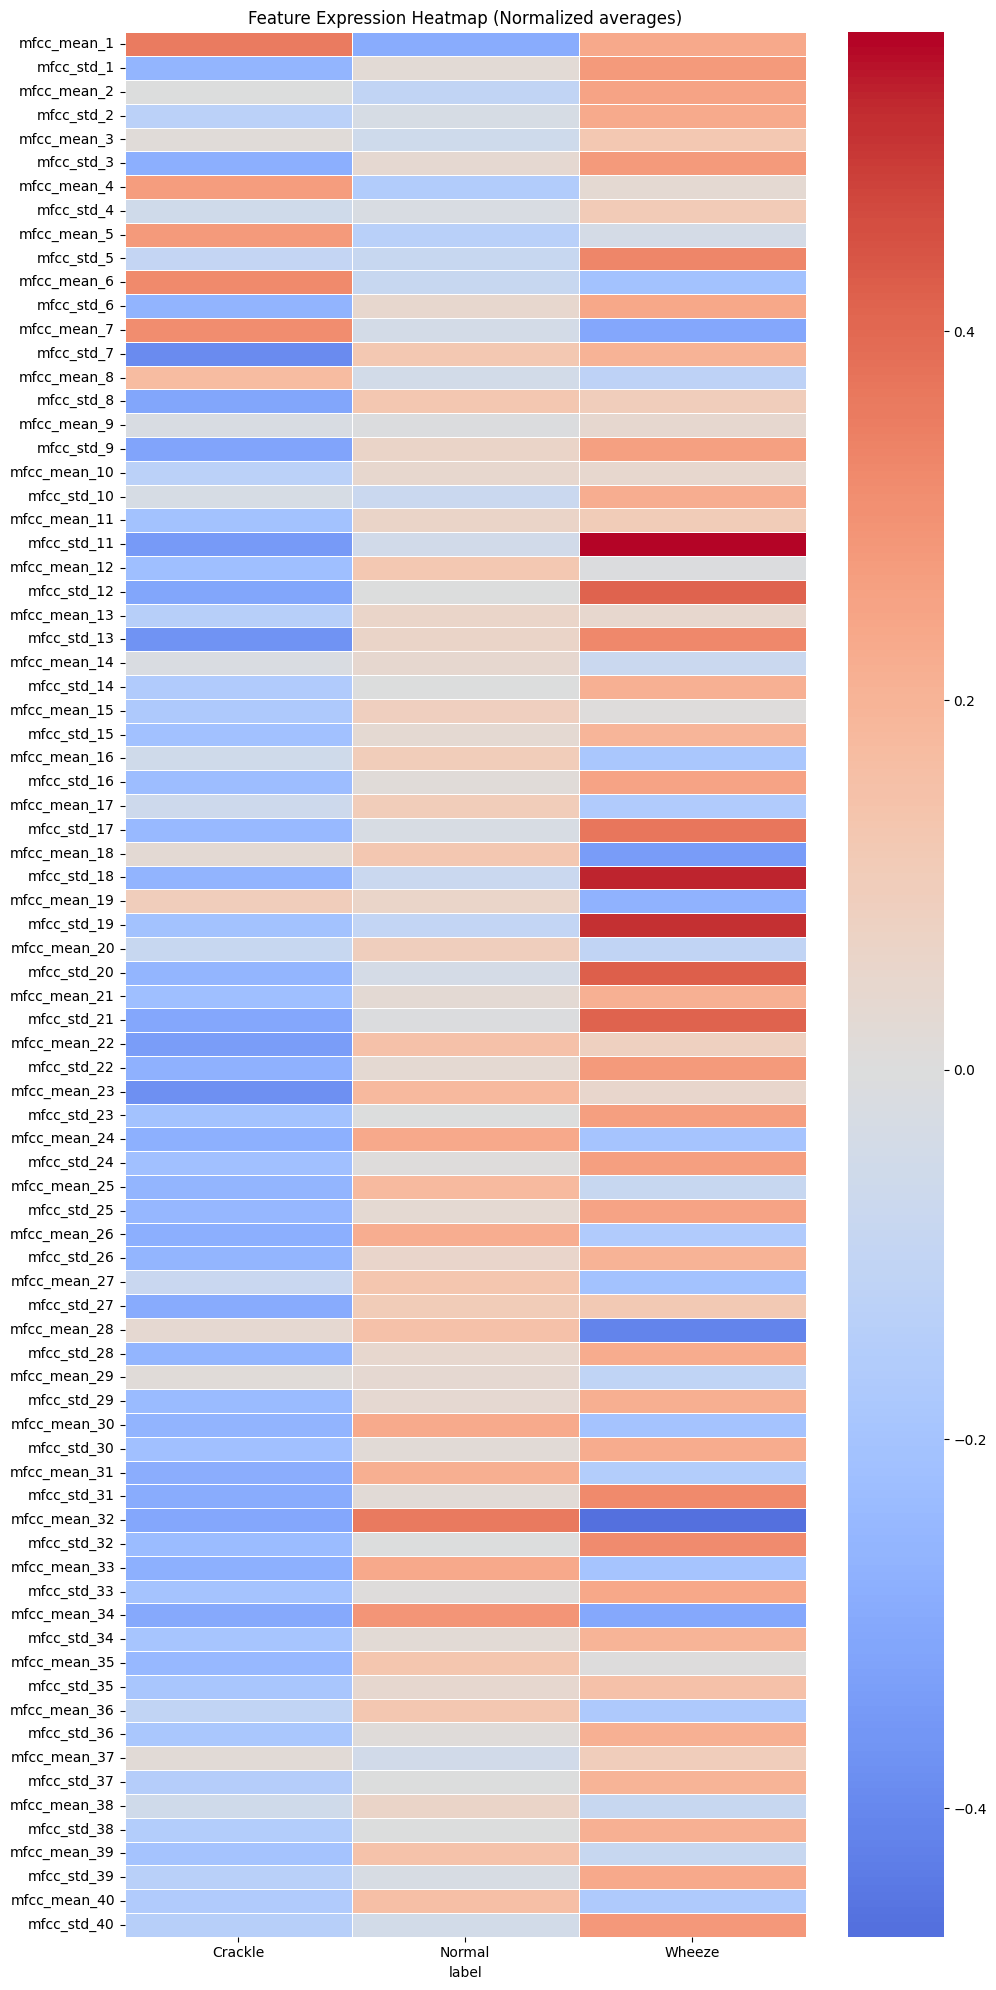


3. Generating Box Plots (Paged)...
  > Saved Page 1 to results_classical\plots_all_features\boxplots_page_1.png
  > Saved Page 2 to results_classical\plots_all_features\boxplots_page_2.png
  > Saved Page 3 to results_classical\plots_all_features\boxplots_page_3.png
  > Saved Page 4 to results_classical\plots_all_features\boxplots_page_4.png
  > Saved Page 5 to results_classical\plots_all_features\boxplots_page_5.png
  > Saved Page 6 to results_classical\plots_all_features\boxplots_page_6.png
  > Saved Page 7 to results_classical\plots_all_features\boxplots_page_7.png

✅ Done! All plots saved in: results_classical\plots_all_features


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
import math
import os

# --- CONFIGURATION ---
SAVE_DIR = 'results_classical'
DATA_FILE = os.path.join(SAVE_DIR, 'features_mfcc.csv')

def visualize_all_features():
    print("--- Starting Full Feature Visualization ---")
    
    # 1. Load Data
    if not os.path.exists(DATA_FILE):
        print(f"Error: Could not find {DATA_FILE}. Please run the extraction script first.")
        return
        
    df = pd.read_csv(DATA_FILE)
    features = [c for c in df.columns if c != 'label']
    
    # Create a sub-directory for plots to keep things organized
    PLOT_DIR = os.path.join(SAVE_DIR, 'plots_all_features')
    os.makedirs(PLOT_DIR, exist_ok=True)

    # --- PART A: STATISTICAL TABLES ---
    print("\n1. Calculating Stats for ALL features...")
    # Group by label and calculate mean/std for every feature
    stats = df.groupby('label').agg(['mean', 'std'])
    stats.to_csv(os.path.join(SAVE_DIR, 'descriptive_stats_all_features.csv'))
    print("Stats saved to 'descriptive_stats_all_features.csv'")

    # --- PART B: GLOBAL HEATMAP (ALL FEATURES) ---
    print("\n2. Generating Global Heatmap...")
    
    # We must normalize data first, otherwise loud features hide quiet ones
    df_numeric = df[features]
    df_normalized = (df_numeric - df_numeric.mean()) / df_numeric.std()
    df_normalized['label'] = df['label']
    
    # Calculate mean of normalized features per class
    heatmap_data = df_normalized.groupby('label').mean().T # Transpose for better shape
    
    plt.figure(figsize=(10, 20)) # Tall figure to fit all feature names
    sns.heatmap(heatmap_data, cmap='coolwarm', center=0, annot=False, linewidths=.5)
    plt.title('Feature Expression Heatmap (Normalized averages)')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, 'global_feature_heatmap.png'))
    plt.show()

    # --- PART C: PAGED BOX PLOTS (ALL FEATURES) ---
    print("\n3. Generating Box Plots (Paged)...")
    
    # Settings: 12 plots per page (4 rows x 3 cols)
    plots_per_page = 12
    num_pages = math.ceil(len(features) / plots_per_page)
    
    for page in range(num_pages):
        start_idx = page * plots_per_page
        end_idx = start_idx + plots_per_page
        current_features = features[start_idx:end_idx]
        
        # Setup Grid
        rows = 4
        cols = 3
        fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
        axes = axes.flatten()
        
        fig.suptitle(f'Feature Distributions - Page {page+1}/{num_pages}', fontsize=16)
        
        for i, feature in enumerate(current_features):
            # Plot
            sns.boxplot(data=df, x='label', y=feature, hue='label', palette='Set2', ax=axes[i], legend=False)
            
            # Add simple ANOVA score title
            f_score, _ = f_classif(df[[feature]], df['label'])
            axes[i].set_title(f"{feature} (F={f_score[0]:.1f})", fontsize=10)
            axes[i].tick_params(axis='x', rotation=15)
            axes[i].grid(True, linestyle='--', alpha=0.3)
            axes[i].set_xlabel('')
            
        # Hide empty subplots on the last page
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
            
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Make space for suptitle
        save_path = os.path.join(PLOT_DIR, f'boxplots_page_{page+1}.png')
        plt.savefig(save_path)
        print(f"  > Saved Page {page+1} to {save_path}")
        plt.close(fig) # Close to free memory

    print(f"\n✅ Done! All plots saved in: {PLOT_DIR}")

# --- EXECUTION ---
if __name__ == "__main__":
    visualize_all_features()